1. Import libraries

2. Read in DOC flux file. The thing we actually want from this file is the z_w_bot coordinate, which tells us the bottom of each grid cell in cm (thus the divide by 100).

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors as c

In [3]:
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/year_1/DIA_IMPVF_DOC/'
fnam = 'b.e21.BHISTsmbb.f09_g17.LE2-1301.012.pop.h.ecosys.nyear1.DIA_IMPVF_DOC.2001-2010.nc'

var = xr.open_dataset(fdir + fnam)
print(var['DIA_IMPVF_DOC'])
print(var['z_w_bot']/100)

<xarray.DataArray 'DIA_IMPVF_DOC' (time: 10, z_w_bot: 60, nlat: 384, nlon: 320)>
[73728000 values with dtype=float32]
Coordinates:
  * z_w_bot  (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
  * time     (time) object 2001-01-01 00:00:00 ... 2010-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     DOC Flux Across Bottom Face from Diabatic Implicit Vertica...
    units:         mmol/m^3 cm/s
    grid_loc:      3113
    cell_methods:  time: mean
<xarray.DataArray 'z_w_bot' (z_w_bot: 60)>
array([  10.     ,   20.     ,   30.     ,   40.     ,   50.     ,
         60.     ,   70.     ,   80.     ,   90.     ,  100.     ,
        110.     ,  120.     ,  130.     ,  140.     ,  150.     ,
        160.     ,  170.19682,  180.76129,  191.82124,  203.49931,
        215.92343,  229.23312,  243.

3. Loop through all grid cells and all depths of the water column, setting the desired variable 'gcdep' (grid cell depth) to the bottom-most non-nan value.

In [6]:
gcdep = np.zeros([384,320])
for i in np.arange(0,384):
    if i%20 == 0:
        print(i)
    for j in np.arange(0,320):
        for dep in np.arange(0,60):
            if np.isnan(var['DIA_IMPVF_DOC'][0,dep,i,j]) == False:
                gcdep[i,j] = var['z_w_bot'][dep]/100
            else:
                break

0
20
40
60
80
120
140
160
180
200
220
240
260
280
300
320
340
360
380


4. Print out gcdep and open it up again, because step 3 takes forever!

In [7]:
dir = open("/glade/u/home/cpayne/PredictPerfect/Input/gridcelldepth.txt", "w")
for row in gcdep:
    np.savetxt(dir, row)
dir.close()

In [2]:
dir = np.loadtxt("/glade/u/home/cpayne/PredictPerfect/Input/gridcelldepth.txt")
gcdep = dir.reshape(384,320)

5. Make areacello_ocn variable, which is ocean area for grid cells inside of the Arctic (latitude > 50°N) and in the ocean (without DOC flux values)

In [ ]:
# a. Read in the areacello file and use this to weight each variable by the area of the grid cell.
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(var['DIA_IMPVF_DOC'][0,0,i,j]) == False and var["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]
            

6. Make lon and lat variables that don't have weird holes in them

In [5]:
lon, lat = var.TLONG.values, var.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)

7. Set the mask criteria. Here, shelfmask is set to:
- 1 in the shelf (<1000m) of the sub-Arctic (50-66.5°N)
- 2 in the shelf (<1000m) of the Arctic (> 66.5°N)
- 3 in the basin (>1000m) of the sub-Arctic (50-66.5°N)
- 4 in the basin (>1000m) of the Arctic (> 66.5°N)

Also I've mapped it to just check that it looks as expected, and output it to the "Input" folder

In [50]:
shelfmask = np.full([384,320], np.nan);
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            if gcdep[i,j] < 1000:
                shelfmask[i,j] = 1 #Shallow, sub-Arctic
            if gcdep[i,j] > 1000:
                shelfmask[i,j] = 3 #Deep, sub-Arctic
            if lat[i,j] > 66.5:
                if gcdep[i,j] < 1000:
                    shelfmask[i,j] = 2 #Shallow, Arctic
                if gcdep[i,j] > 1000:
                    shelfmask[i,j] = 4 #Deep, Arctic

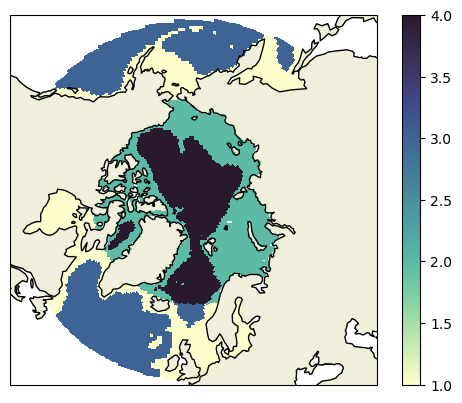

In [56]:
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_extent([-180, 180, 49, 90], crs = ccrs.PlateCarree());
pc = ax.pcolormesh(lon, lat, shelfmask, transform=ccrs.PlateCarree(), vmin = 1, vmax = 4, cmap = 'cmo.deep');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc);


In [54]:
dir = open("/glade/u/home/cpayne/PredictPerfect/Input/shelfmask.txt", "w")
for row in shelfmask:
    np.savetxt(dir, row)
dir.close()

In [2]:
dir = np.loadtxt("/glade/u/home/cpayne/PredictPerfect/Input/shelfmask.txt")
shelfmask = dir.reshape(384,320)

AttributeError: 'tuple' object has no attribute 'shape'

In [47]:
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_extent([-180, 180, 49, 90], crs = ccrs.PlateCarree());
shelf = ma.masked_array(shelfmask, shelfmask != 2)
pc = ax.pcolormesh(lon, lat, shelfmask, transform=ccrs.PlateCarree(), cmap = c.ListedColormap(['black']), vmin = 0, vmax = 4);
pc = ax.pcolormesh(lon, lat, shelf, transform=ccrs.PlateCarree(), cmap = c.ListedColormap(['limegreen']), vmin = 0, vmax = 1);
ax.coastlines();  ax.add_feature(cfeature.LAND);
figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/shelfarc.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
plt.close()


In [12]:
vdir = 'ocn'
vnam = 'photoC_diat_zint_2'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'
fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

# Interpolate lat and lon values over holes in the arrays
ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)


In [25]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#fig = plt.figure(figsize=(3,3)) 
# fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
shelf = ma.masked_array(shelfmask, shelfmask != 2)
#pc = ax.pcolormesh(lon, lat, shelfmask, transform=ccrs.PlateCarree(), cmap = c.ListedColormap(['limegreen']), vmin = 0, vmax = 4);
pc = ax.pcolormesh(lon, lat, shelf, transform=ccrs.PlateCarree(), cmap = c.ListedColormap(['limegreen']), vmin = 0, vmax = 1);
ax.coastlines();  ax.add_feature(cfeature.LAND);
figdir = '/glade/u/home/cpayne/shelfhighlight.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
plt.close()